In [2]:
include("../sensor.jl") # To retrieve Sensor Positions
include("../doa/cbf.jl") # Conventional Beamformer
include("../doa/dbf_freeform.jl") # Differential Beamformer (coordinate-free) 
include("../doa/music.jl") # MUSIC

include("../utils/preprocess.jl")

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


In [56]:
#=
Step 0: Open recording or generate signal
=#

# To Generate Signal:
include("../signal_generator/tone.jl")

freq = 50;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 10;       # Duration of Tone (in seconds)
sample_rate = 32000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);

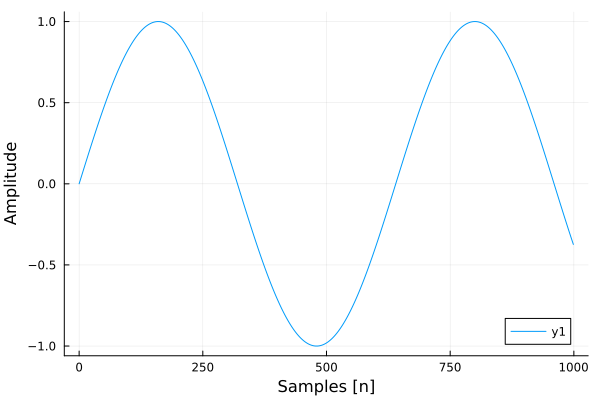

In [57]:
using Plots
plot(n[1:1000], tone_sig[1:1000, 1])
xlabel!("Samples [n]")
ylabel!("Amplitude")

In [58]:
# Note: Please use Floating Point Numbers for Azimuth Angles
include("../signal_generator/generate_sig.jl")
using DSP.Windows: hanning, rect, bartlett
az_gt = -90.0;        # Ground Truth Azimuth Angle (in degrees)
az_gt2 = 120.0;     # Ground Truth Azimuth Angle (in degrees)
c0 = 343;          # Speed of Medium (in m/s)
NFFT = 2^11;
noverlap = Int(NFFT * (3 // 4));
sig1, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors, az_gt, c0);
sig2, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors, az_gt2, c0); 
new_sig = sig1 + sig2;


Start Simulating Signal
Signal has size: (320000, 1)
Using FFT for Delaying


  0.122564 seconds (286 allocations: 126.970 MiB)
Now Generated Signal has size: (320000, 8)
Start Simulating Signal
Signal has size: (320000, 1)
Using FFT for Delaying


  0.350863 seconds (286 allocations: 126.970 MiB, 60.83% gc time)
Now Generated Signal has size: (320000, 8)


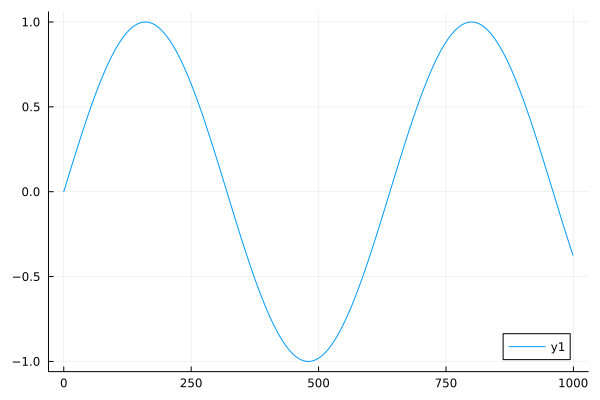

In [59]:
start = 1;
ending = 1000;
plot(n[start:ending], real(sig1[start:ending, 1]))

In [60]:
# Add Noise
using Random
using DSP: db2amp
using SignalAnalysis: PinkGaussian
rng = Random.seed!(1234);
noise_pow = 0; # in dB
noise = rand(rng, size(new_sig,1), size(new_sig,2))
rng = Random.seed!(1234);
pink_noise = rand(rng, PinkGaussian(size(new_sig, 1), 2.0));
noisy_sig = new_sig + db2amp(noise_pow) .* noise;
noisy_sig1 = sig1 + db2amp(noise_pow) .* noise;
noisy_sig2 = sig2 + db2amp(noise_pow) .* noise;

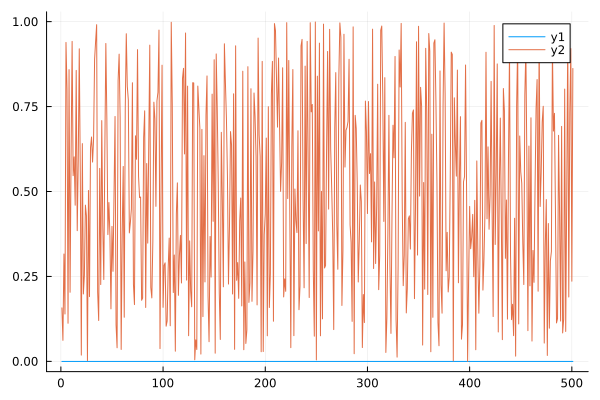

In [61]:
using Plots
T_plot = 500;
start = 64000;
plot(real(new_sig[start:start+T_plot,1]))
plot!(real(noisy_sig[start:start+T_plot,1]))

In [62]:
#= 
Step 1: Pre-process Signal by selecting 
        Frequency of Interest at each channel
        (FFT instead of STFT)
=#
function filter_freq_per_ch(new_sig, freq_interest)
# freq_interest = freq; # (Hz)
    new_S = []
    NFFT = size(new_sig, 1);
    frequencies = sample_rate/NFFT*(0:(NFFT-1));
    (_, freq_idx) = findmin( abs.(frequencies .- freq_interest) );

    for signal in eachcol(new_sig)
        S_interest = fft(signal);
        S_interest = S_interest[freq_idx];
        push!(new_S, S_interest);
    end
    return new_S
end

new_S = filter_freq_per_ch(new_sig, freq);
new_S1 = filter_freq_per_ch(sig1, freq);
new_S2 = filter_freq_per_ch(sig2, freq);

In [63]:
Rx = (1 ./ 1) .* new_S * new_S';
order = 3;
@time P_cbf, az_list = cbf(Rx, sensors, freq, c0)
@time P_dbf, az_list, ___, dbf_filters = dbf_coFree(Rx, sensors, order, freq, c0)
Rx1 = (1 ./ 1) .* new_S1 * new_S1';
@time P1_cbf, az_list = cbf(Rx1, sensors, freq, c0)
@time P1_dbf, az_list = dbf_coFree(Rx1, sensors, order, freq, c0)
Rx2 = (1 ./ 1) .* new_S2 * new_S2';
@time P2_cbf, az_list = cbf(Rx2, sensors, freq, c0)
@time P2_dbf, az_list = dbf_coFree(Rx2, sensors, order, freq, c0)

P_music, az_list = music(Rx, sensors, 2, freq, c0);
P1_music, az_list = music(Rx, sensors, 1, freq, c0);
P2_music, az_list = music(Rx, sensors, 1, freq, c0);

  0.072065 seconds (289.97 k allocations: 14.858 MiB, 99.14% compilation time: 100% of which was recompilation)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.000949 seconds (11.48 k allocations: 683.773 KiB)
  0.000548 seconds (4.35 k allocations: 384.562 KiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.002042 seconds (11.47 k allocations: 684.477 KiB)
  0.000680 seconds (4.35 k allocations: 384.562 KiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001056 seconds (11.47 k allocations: 683.195 KiB)


In [64]:
function normalize_P(P, az_list) 
    (P_max, max_idx) = findmax(P);
    return (P ./ P_max), az_list[max_idx]
end

P_cbf_norm, az_cbf_max = normalize_P(P_cbf, az_list)
P_dbf_norm, az_dbf_max = normalize_P(P_dbf, az_list)
P_music_norm, az_music_max = normalize_P(P_music, az_list)
P1_cbf_norm, az1_cbf_max = normalize_P(P1_cbf, az_list)
P1_dbf_norm, az1_dbf_max = normalize_P(P1_dbf, az_list)
P1_music_norm, az1_music_max = normalize_P(P1_music, az_list)
P2_cbf_norm, az2_cbf_max = normalize_P(P2_cbf, az_list)
P2_dbf_norm, az2_dbf_max = normalize_P(P2_dbf, az_list)
P2_music_norm, az2_music_max = normalize_P(P2_music, az_list)

([0.9689677263247276, 0.9728395144261608, 0.9764773834482069, 0.9798746143064064, 0.9830248521106757, 0.9859221343655427, 0.9885609179077276, 0.9909361043617732, 0.9930430639001101, 0.9948776571084581  …  0.9248455561627347, 0.93047507742232, 0.9359425493530938, 0.9412393423860876, 0.9463569169636734, 0.951286853312285, 0.9560208818354786, 0.9605509139508533, 0.9648690731845208, 0.9689677263247276], -165.0)

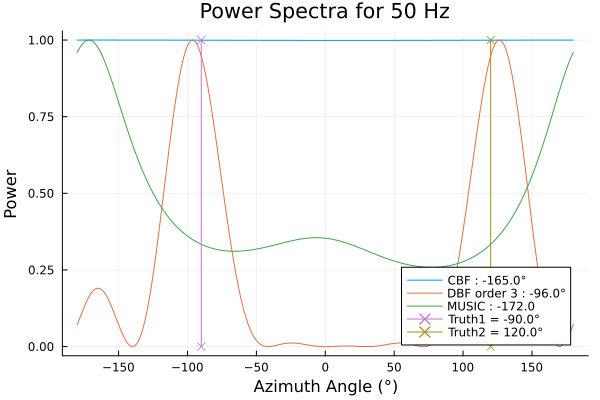

In [65]:
plot(az_list, P_cbf_norm, label="CBF : $(az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
title!("Power Spectra for $freq Hz")
plot!(az_list, P_dbf_norm, label="DBF order $order : $(az_dbf_max)°")
plot!(az_list, P_music_norm, label="MUSIC : $(az_music_max)")
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")
# savefig("../plots/additive_spectra.png")

In [66]:
function power_filtering(Rx, filters)
    P_list = [];
    for filter in filters
        P = filter' * Rx * filter;
        append!(P_list, abs.(P))
    end
    return P_list
end

power_filtering (generic function with 1 method)

In [67]:
eig, Rs, Rn = get_eigensubspace(Rx, 2);
eig1, Rs1, Rn1 = get_eigensubspace(Rx1, 1);
eig2, Rs2, Rn2 = get_eigensubspace(Rx2, 1);
P_dbf_music = power_filtering(Rn, dbf_filters);
P1_dbf_music = power_filtering(Rn1, dbf_filters);
P2_dbf_music = power_filtering(Rn2, dbf_filters);

P_dbf_music_norm, az_music_dbf_max = normalize_P(P_dbf_music, az_list)
P1_dbf_music_norm, az1_music_dbf_max = normalize_P(P1_dbf_music, az_list)
P2_dbf_music_norm, az2_music_dbf_max = normalize_P(P2_dbf_music, az_list)

([0.999999988382767, 0.9999999883964239, 0.999999988438304, 0.9999999885082099, 0.999999988605807, 0.9999999887306243, 0.9999999888820581, 0.9999999890593754, 0.9999999892617143, 0.9999999894880924  …  0.9999999894945354, 0.999999989267862, 0.9999999890650837, 0.9999999888871974, 0.9999999887350826, 0.9999999886094891, 0.9999999885110393, 0.999999988440223, 0.999999988397393, 0.999999988382767], -135.0)

In [68]:
plot(az_list, P_music_norm, label="MUSIC (CBF Weights) : $(az_music_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
title!("Power Spectra for $freq Hz")
plot!(az_list, P_dbf_music_norm, label="MUSIC (DBF Weights) : $(az_music_dbf_max)°")
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")
savefig("../plots/music_spectra_$(freq)Hz.png")

"/Users/odas2/Desktop/SoundMapping/doa_branch/localization/plots/music_spectra_50Hz.png"

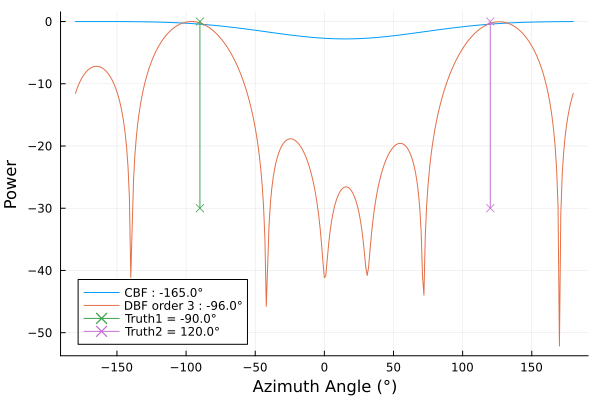

In [26]:
plot(az_list, pow2db.(P_cbf_norm), label="CBF : $(az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, pow2db.(P_dbf_norm), label="DBF order $order : $(az_dbf_max)°")
plot!([az_gt; az_gt], [-30; 0], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [-30; 0], marker=:x, label="Truth2 = $(az_gt2)°")

In [27]:
plot(az_list, P_cbf_norm, label="CBF : $(az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
title!("Power Spectra for $freq Hz")
plot!(az_list, P1_cbf_norm, label="CBF1 : $(az1_cbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_cbf_norm, label="CBF2 : $(az2_cbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")
# savefig("../plots/cbf_additive_spectra.png")

"/Users/odas2/Desktop/SoundMapping/doa_branch/localization/plots/cbf_additive_spectra.png"

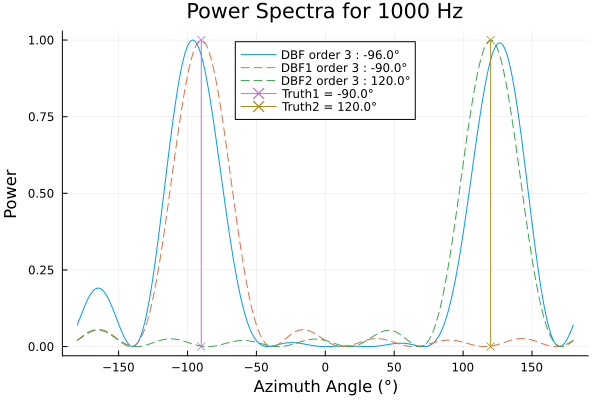

In [31]:
plot(az_list, P_dbf_norm, label="DBF order $order : $(az_dbf_max)°", legend=:top)
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
title!("Power Spectra for $freq Hz")
plot!(az_list, P1_dbf_norm, label="DBF1 order $order : $(az1_dbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_dbf_norm, label="DBF2 order $order : $(az2_dbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")
# savefig("../plots/dbf_additive_spectra.png")

In [29]:
noisy_S = filter_freq_per_ch(noisy_sig, freq);
noisy_S1 = filter_freq_per_ch(noisy_sig1, freq);
noisy_S2 = filter_freq_per_ch(noisy_sig2, freq);

noisy_Rx = (1 ./ 1) .* noisy_S * noisy_S';
order = 3;
@time Pn_cbf, az_list = cbf(noisy_Rx, sensors_underwater, freq, c0)
@time Pn_dbf, az_list = dbf_coFree(noisy_Rx, sensors_underwater, order, freq, c0)
noisy_Rx1 = (1 ./ 1) .* noisy_S1 * noisy_S1';
@time P1n_cbf, az_list = cbf(noisy_Rx1, sensors_underwater, freq, c0)
@time P1n_dbf, az_list = dbf_coFree(noisy_Rx1, sensors_underwater, order, freq, c0)
noisy_Rx2 = (1 ./ 1) .* noisy_S2 * noisy_S2';
@time P2n_cbf, az_list = cbf(noisy_Rx2, sensors_underwater, freq, c0)
@time P2n_dbf, az_list = dbf_coFree(noisy_Rx2, sensors_underwater, order, freq, c0)

DimensionMismatch: DimensionMismatch: second dimension of A, 8, does not match length of x, 40

In [30]:
Pn_cbf_norm, n_az_cbf_max = normalize_P(Pn_cbf, az_list)
Pn_dbf_norm, n_az_dbf_max = normalize_P(Pn_dbf, az_list)
P1n_cbf_norm, n_az1_cbf_max = normalize_P(P1n_cbf, az_list)
P1n_dbf_norm, n_az1_dbf_max = normalize_P(P1n_dbf, az_list)
P2n_cbf_norm, n_az2_cbf_max = normalize_P(P2n_cbf, az_list)
P2n_dbf_norm, n_az2_dbf_max = normalize_P(P2n_dbf, az_list)

UndefVarError: UndefVarError: Pn_cbf not defined

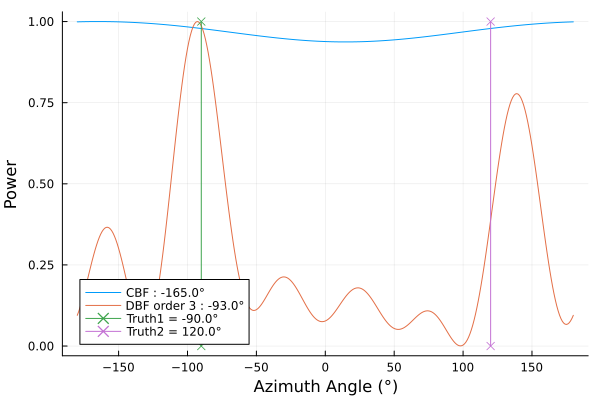

In [32]:
plot(az_list, Pn_cbf_norm, label="CBF : $(n_az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, Pn_dbf_norm, label="DBF order $order : $(n_az_dbf_max)°")
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

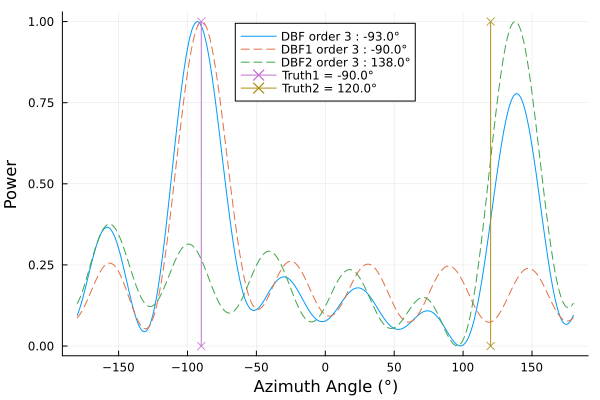

In [35]:
plot(az_list, Pn_dbf_norm, label="DBF order $order : $(n_az_dbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1n_dbf_norm, label="DBF1 order $order : $(n_az1_dbf_max)°",
    linestyle=:dash);
plot!(az_list, P2n_dbf_norm, label="DBF2 order $order : $(n_az2_dbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°", legend=:top)

In [58]:
include("../doa/mdbf.jl")

wng_pow=db2pow(0);
@time P_mdbf, az_list = mdbf(Rx, sensors_underwater, order, freq, c0, wng_pow);
@time P1_mdbf, az_list = mdbf(Rx1, sensors_underwater, order, freq, c0, wng_pow);
@time P2_mdbf, az_list = mdbf(Rx2, sensors_underwater, order, freq, c0, wng_pow);

P_mdbf_norm, az_mdbf_max = normalize_P(P_mdbf, az_list);
P1_mdbf_norm, az1_mdbf_max = normalize_P(P1_mdbf, az_list);
P2_mdbf_norm, az2_mdbf_max = normalize_P(P2_mdbf, az_list);

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.893221 seconds (2.60 M allocations: 271.838 MiB, 24.12% compilation time)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.727774 seconds (1.87 M allocations: 237.982 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.968664 seconds (1.87 M allocations: 237.982 MiB, 20.54% gc time)


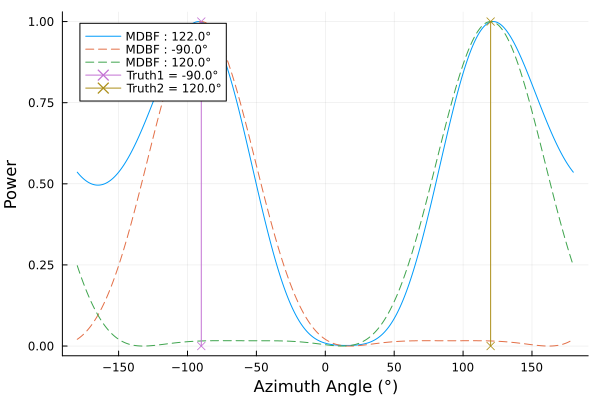

In [59]:
plot(az_list, P_mdbf_norm, label="MDBF : $(az_mdbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power")
plot!(az_list, P1_mdbf_norm, label="MDBF : $(az1_mdbf_max)°",
        linestyle=:dash)
plot!(az_list, P2_mdbf_norm, label="MDBF : $(az2_mdbf_max)°",
        linestyle=:dash)
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

In [65]:
wng_pow=db2pow(noise_pow);
@time Pn_mdbf, az_list = mdbf(noisy_Rx, sensors_underwater, order, freq, c0, wng_pow);
@time P1n_mdbf, az_list = mdbf(noisy_Rx1, sensors_underwater, order, freq, c0, wng_pow);
@time P2n_mdbf, az_list = mdbf(noisy_Rx2, sensors_underwater, order, freq, c0, wng_pow);

Pn_mdbf_norm, n_az_mdbf_max = normalize_P(Pn_mdbf, az_list);
P1n_mdbf_norm, n_az1_mdbf_max = normalize_P(P1n_mdbf, az_list);
P2n_mdbf_norm, n_az2_mdbf_max = normalize_P(P2n_mdbf, az_list);

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.735458 seconds (1.87 M allocations: 237.981 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.822708 seconds (1.87 M allocations: 237.981 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


  0.801200 seconds (1.87 M allocations: 237.981 MiB)


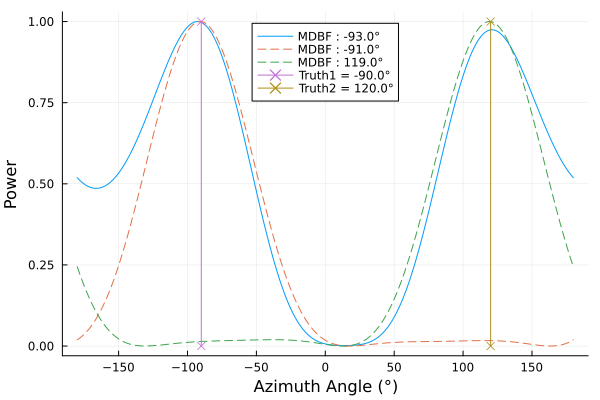

In [66]:
plot(az_list, Pn_mdbf_norm, label="MDBF : $(n_az_mdbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power")
plot!(az_list, P1n_mdbf_norm, label="MDBF : $(n_az1_mdbf_max)°",
        linestyle=:dash)
plot!(az_list, P2n_mdbf_norm, label="MDBF : $(n_az2_mdbf_max)°",
        linestyle=:dash)
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°",
        legend=:top)

In [1]:
include("../doa/music.jl")
eigenvals, Rs, Rn = get_eigensubspace(Rx, 2);

UndefVarError: UndefVarError: Rx not defined